# Setup Libraries

In [3]:
# --- Install required packages ---
!pip install cdsapi

# --- System & API ---
import os
import tempfile
import random
import cdsapi

# --- Core Python Libraries ---
import copy
import math
import calendar

# --- Data Handling ---
import numpy as np
import pandas as pd
import xarray as xr

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning: TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2

# --- Preprocessing & Metrics ---
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Import and Visualization

The training data used for the CNN model spans the years 2000 and 2001,
while the test data is from 2002. Each sample includes 13 predictor variables
derived from ERA5 climate data, including:

- 2m_temperature: mean, min, max  
- 2m_dewpoint_temperature: mean, min, max  
- skin_temperature: mean, min, max  
- total_precipitation: sum  
- evaporation: sum  
- total_column_water_vapour: sum  
- total_cloud_cover: sum

The target variable is the Standardized Precipitation-Evapotranspiration Index (SPEI), a widely used drought index. Its values can be interpreted as follows:

| SPEI Value       | Drought Category      |
|------------------|------------------------|
| ≥ 2.0            | Extremely Wet          |
| 1.5 to 1.99      | Very Wet               |
| 1.0 to 1.49      | Moderately Wet         |
| -0.99 to 0.99    | Normal                 |
| -1.0 to -1.49    | Moderately Dry         |
| -1.5 to -1.99    | Very Dry               |
| ≤ -2.0           | Extremely Dry          |

In the following section, exploratory data analysis is conducted to better understand the input features and the distribution of the target variable
before training the CNN model.


### Data Import

In [2]:
from google.colab import files
uploaded = files.upload()

Saving raw_test_X.npy to raw_test_X.npy
Saving raw_test_y.npy to raw_test_y.npy
Saving raw_train_X_combined.npy to raw_train_X_combined.npy
Saving raw_train_y_combined.npy to raw_train_y_combined.npy


In [4]:
# Load Training Data
train_X = np.load('raw_train_X_combined.npy')
train_y = np.load('raw_train_y_combined.npy')

print(f"Train X shape: {train_X.shape}")
print(f"Train y shape: {train_y.shape}")

# Load Test Data
test_X = np.load('raw_test_X.npy')
test_y = np.load('raw_test_y.npy')

print(f"Test X shape: {test_X.shape}")
print(f"Test y shape: {test_y.shape}")

Train X shape: (396, 31, 20, 20, 13)
Train y shape: (396, 31, 20, 20, 1)
Test X shape: (198, 31, 20, 20, 13)
Test y shape: (198, 31, 20, 20, 1)


### Data Cleaning

In [5]:
# --- Check for Missing Values and Fill Indicators in Training and Test Data ---

# Check for NaNs in training data
n_nan_train_X = np.isnan(train_X).sum()
n_nan_train_y = np.isnan(train_y).sum()
print(f"Number of NaNs in train_X: {n_nan_train_X}")
print(f"Number of NaNs in train_y: {n_nan_train_y}")

# Check for -9999 placeholders in training data
n_fill_train_X = np.sum(train_X == -9999)
n_fill_train_y = np.sum(train_y == -9999)
print(f"Number of -9999 values in train_X: {n_fill_train_X}")
print(f"Number of -9999 values in train_y: {n_fill_train_y}")

# Check for NaNs in test data
n_nan_test_X = np.isnan(test_X).sum()
n_nan_test_y = np.isnan(test_y).sum()
print(f"Number of NaNs in test_X: {n_nan_test_X}")
print(f"Number of NaNs in test_y: {n_nan_test_y}")

# Check for -9999 placeholders in test data
n_fill_test_X = np.sum(test_X == -9999)
n_fill_test_y = np.sum(test_y == -9999)
print(f"Number of -9999 values in test_X: {n_fill_test_X}")
print(f"Number of -9999 values in test_y: {n_fill_test_y}")

Number of NaNs in train_X: 0
Number of NaNs in train_y: 6200
Number of -9999 values in train_X: 21323809
Number of -9999 values in train_y: 1596562
Number of NaNs in test_X: 0
Number of NaNs in test_y: 31031
Number of -9999 values in test_X: 10683770
Number of -9999 values in test_y: 798281


The presence of -9999 values in `train_X`, `train_y`, `test_X`, and `test_y` stems from the padding process applied during data preparation. To facilitate efficient computation and training, the spatial data is divided into fixed-size blocks. However, when the geographic boundaries do not align perfectly with the block dimensions, some edge blocks end up with fewer valid grid cells than required.

To ensure that all input blocks maintain a consistent shape suitable for the CNN model, these incomplete blocks are padded with the value -9999. This specific value is chosen because it lies far outside the range of any physically plausible climate measurements, making it easily identifiable as artificial padding.

While this approach enables uniformity in the input dimensions, it also introduces the need for careful preprocessing. The model must be trained in a way that ensures it does not interpret the -9999 values as valid data, as doing so could significantly impair predictive performance.

On, the other hand, the missing values (NaNs) in the target variable might result from data coverage gaps. As the number of Nans is relatively small, instead of discarding entire samples, we use linear interpolation to estimate these missing values based on neighbouring valid data.

This method is chosen for its simplicity and ability to preserve the temporal continuity of the data, which is particularly important in climate time series like SPEI. Interpolating avoids introducing large artificial discontinuities and ensures the model receives coherent target signals for learning.

By applying interpolation only along the temporal axis, we maintain spatial structure and avoid cross-contamination between different blocks or regions.


In [6]:
# --- Interpolation over NaNs using linear method (estimates missing values from adjacent valid data points) ---

# Flatten the 3D structure of train_y to 2D for interpolation
train_y_df = pd.DataFrame(train_y.reshape(-1, train_y.shape[-1]))

# Perform linear interpolation along the time axis (axis=0)
train_y_df.interpolate(method='linear', axis=0, inplace=True)

# Reshape back to the original 3D structure
train_y = train_y_df.values.reshape(train_y.shape)

# Repeat the same process for test_y
test_y_df = pd.DataFrame(test_y.reshape(-1, test_y.shape[-1]))
test_y_df.interpolate(method='linear', axis=0, inplace=True)
test_y = test_y_df.values.reshape(test_y.shape)

### Data Standarisation and Visualisation

To better understand the data distribution before and after standardisation, the following code visualises histograms for each channel at three stages: the raw input, after outlier removal, and after standardisation. Visualising these distributions helps identify anomalies and verify that preprocessing was applied correctly.

Channels 7, 11, 12 and 13 contain extremely negative values, which probably represent missing or invalid entries, especially as there are exactly the same number of outliers in all four channels. These were not initially marked as missing but are now properly handled by:
- Replace them with NaN to mark them as missing (treated the same as -9999 values)
- Excluding them from the calculation of standardisation parameters (mean and standard deviation)

The standardisation step then transforms each feature to have zero mean and unit variance, ensuring that all channels contribute equally to the model during training. This preprocessing step is essential to avoid biasing the model toward features with larger numerical ranges and to improve model convergence and performance.

The histograms also display the distribution of the SPEI values.


Original channel means (before outlier removal):
Channel 0: 284.16162109375
Channel 1: 281.0804443359375
Channel 2: 278.3210754394531
Channel 3: 300.7391357421875
Channel 4: 294.2144775390625
Channel 5: 288.0630798339844
Channel 6: -4574.3251953125
Channel 7: 309.8335266113281
Channel 8: 296.02325439453125
Channel 9: 286.9871520996094
Channel 10: -4566.79736328125
Channel 11: -4096.38671875
Channel 12: -4574.32373046875

Outliers removed per channel:
Channel 0: 0 outliers (0.00% of non-NaN values)
Channel 1: 0 outliers (0.00% of non-NaN values)
Channel 2: 0 outliers (0.00% of non-NaN values)
Channel 3: 0 outliers (0.00% of non-NaN values)
Channel 4: 0 outliers (0.00% of non-NaN values)
Channel 5: 0 outliers (0.00% of non-NaN values)
Channel 6: 63167 outliers (1.91% of non-NaN values)
Channel 7: 0 outliers (0.00% of non-NaN values)
Channel 8: 0 outliers (0.00% of non-NaN values)
Channel 9: 0 outliers (0.00% of non-NaN values)
Channel 10: 63167 outliers (1.91% of non-NaN values)
Channel 

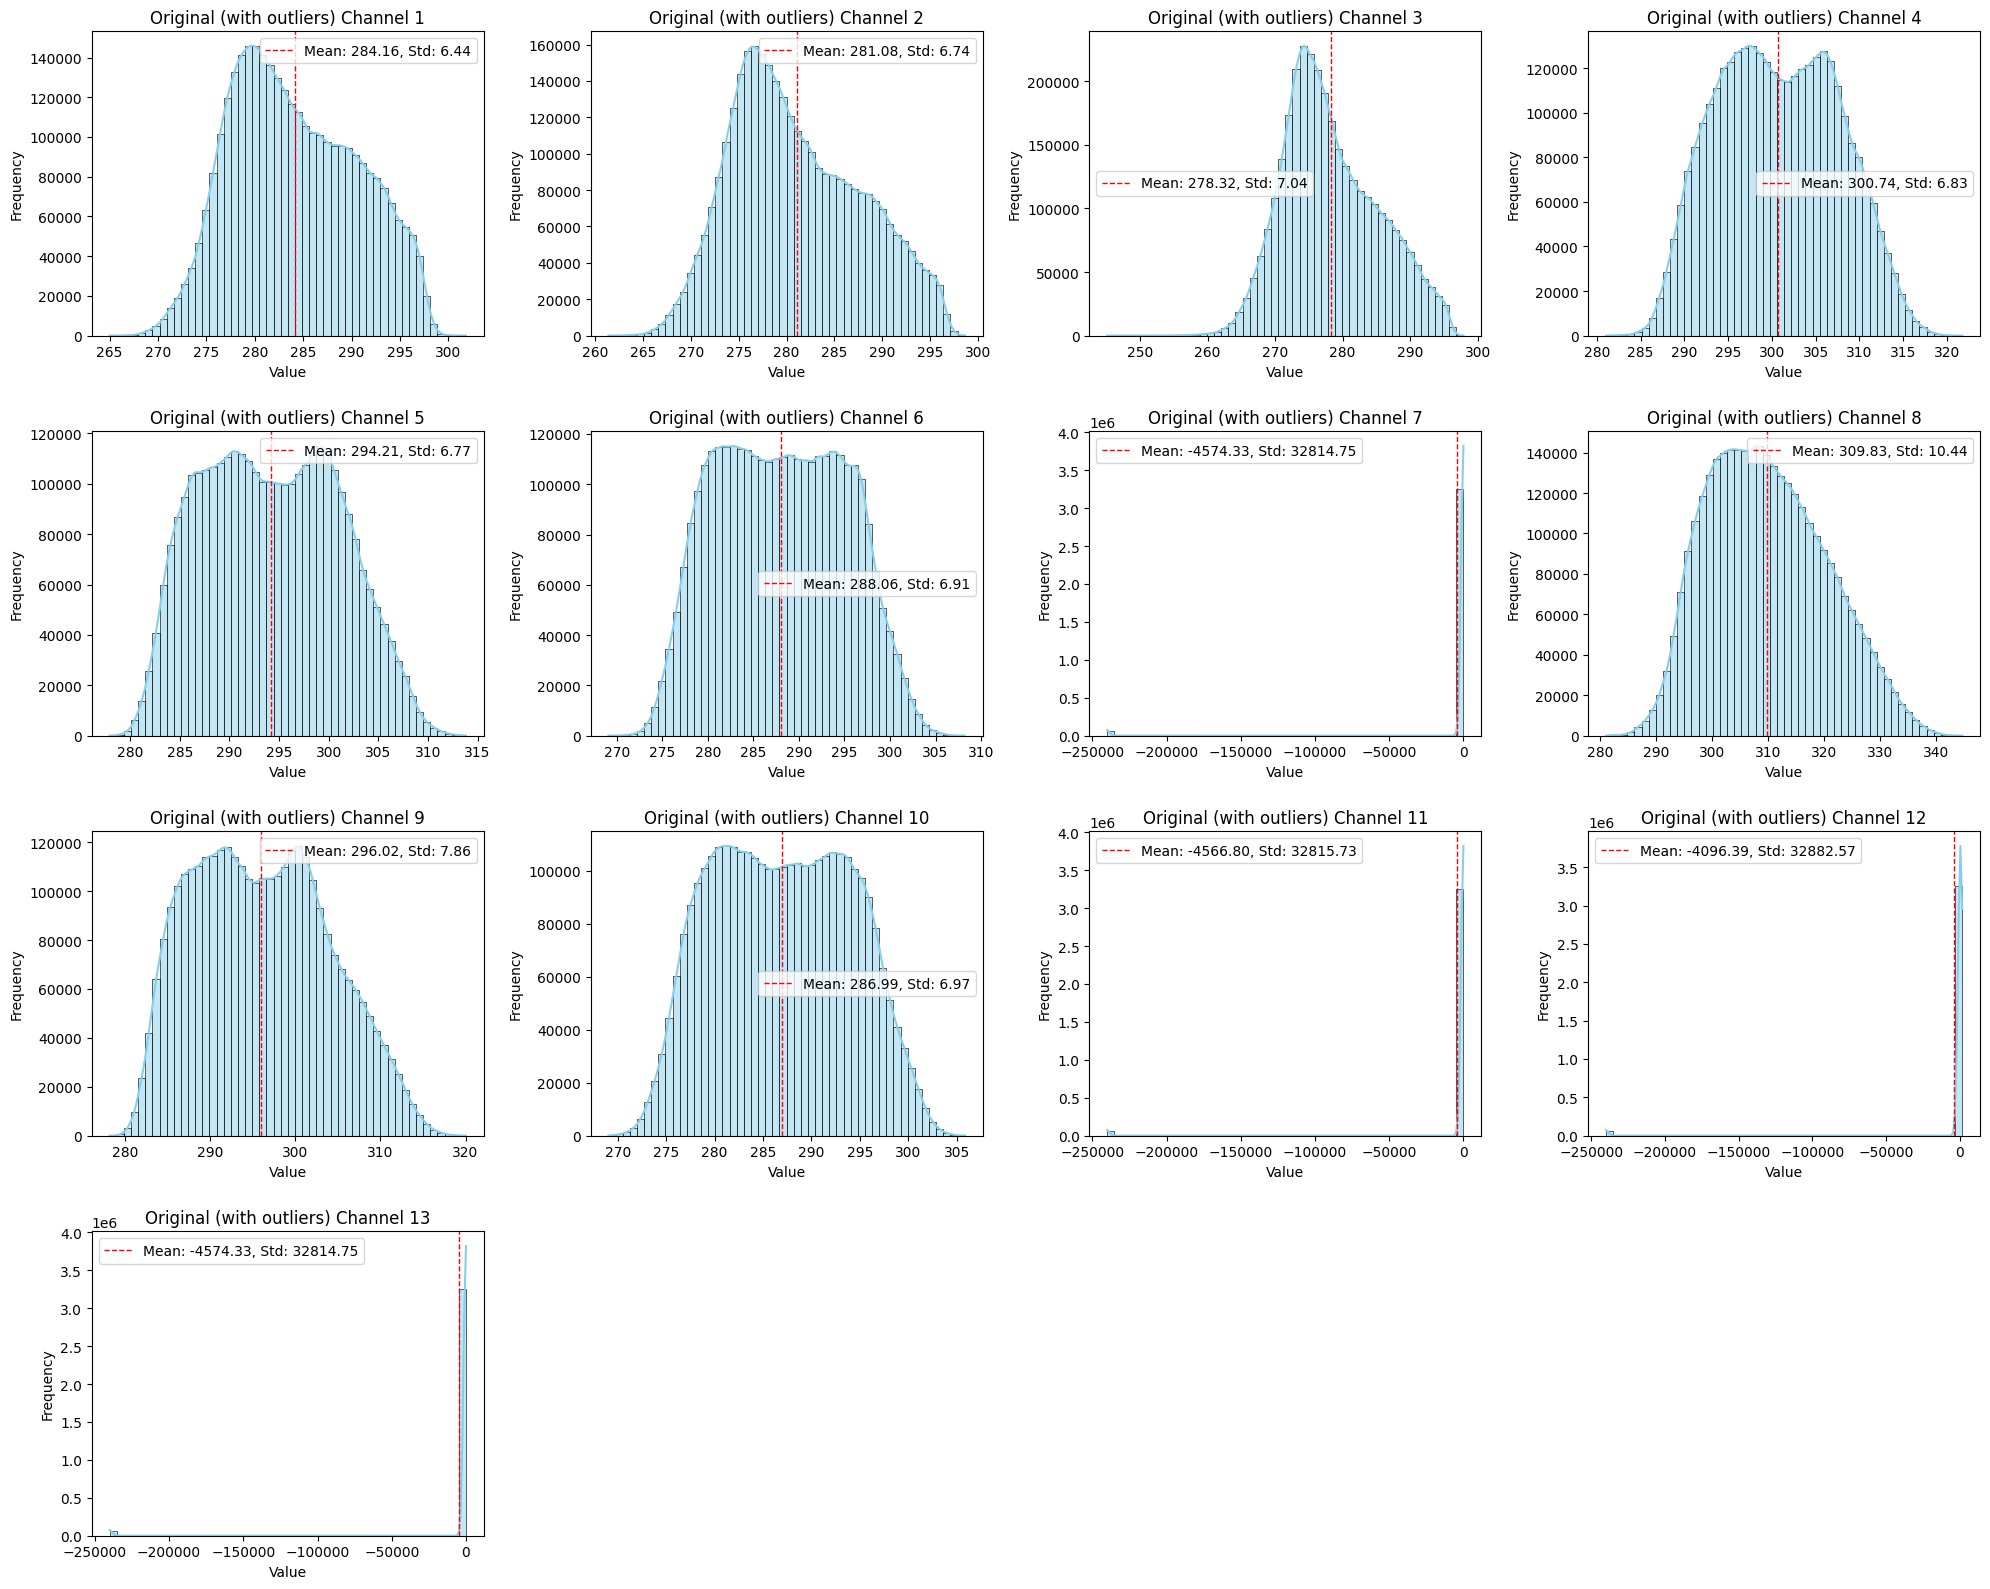

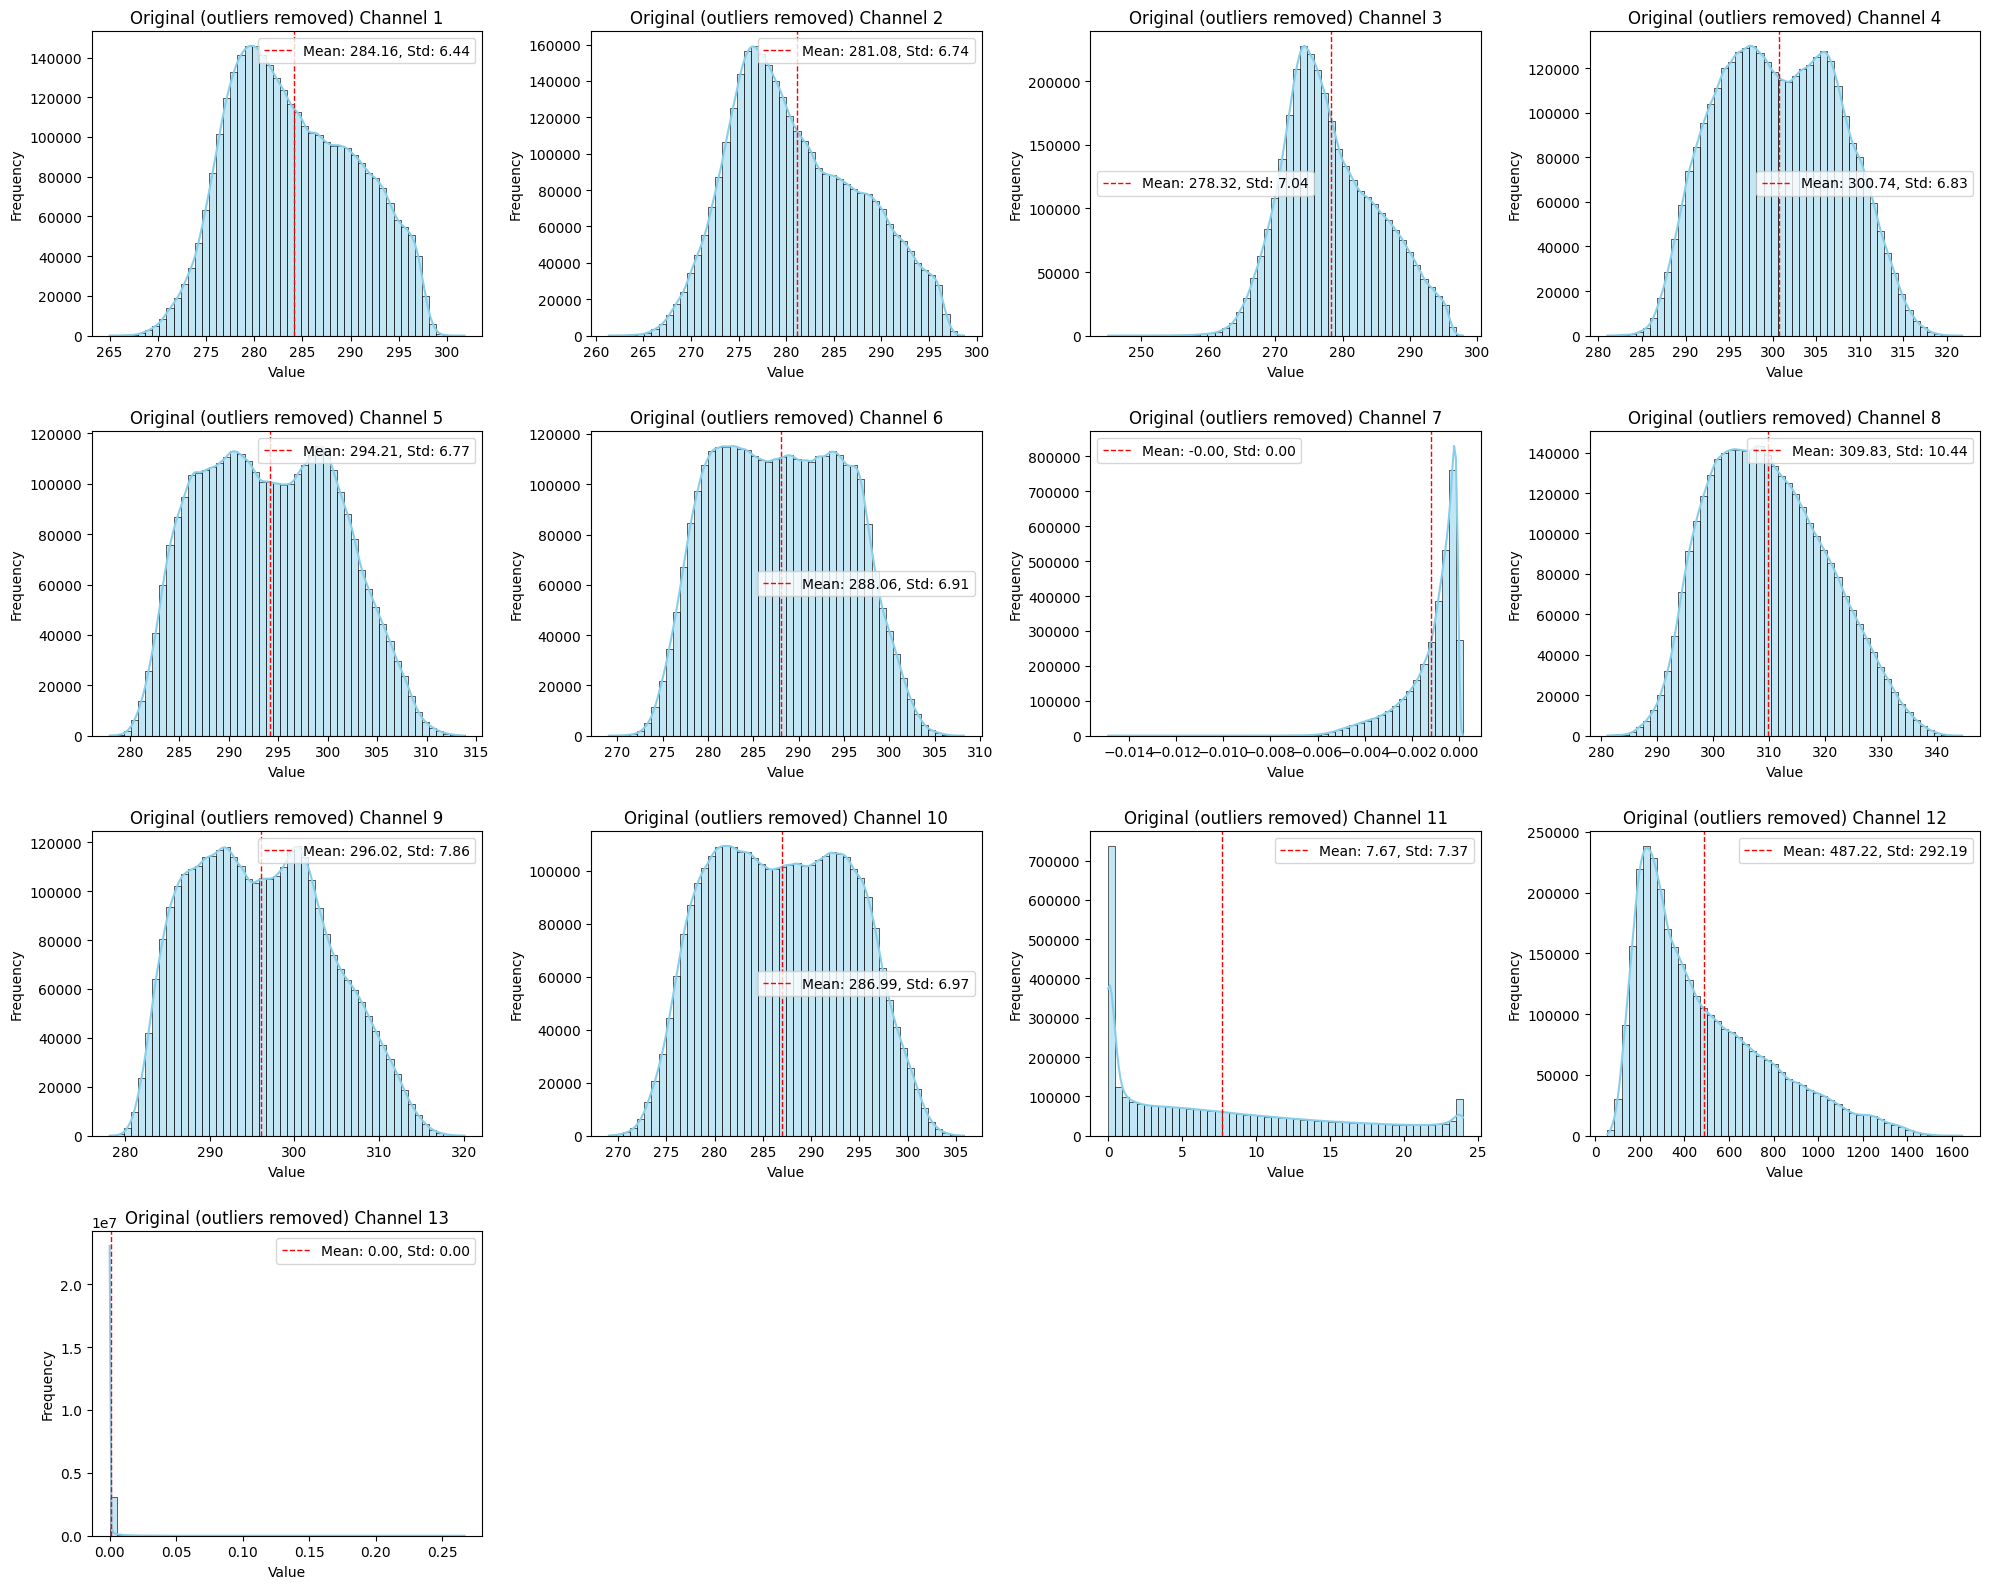

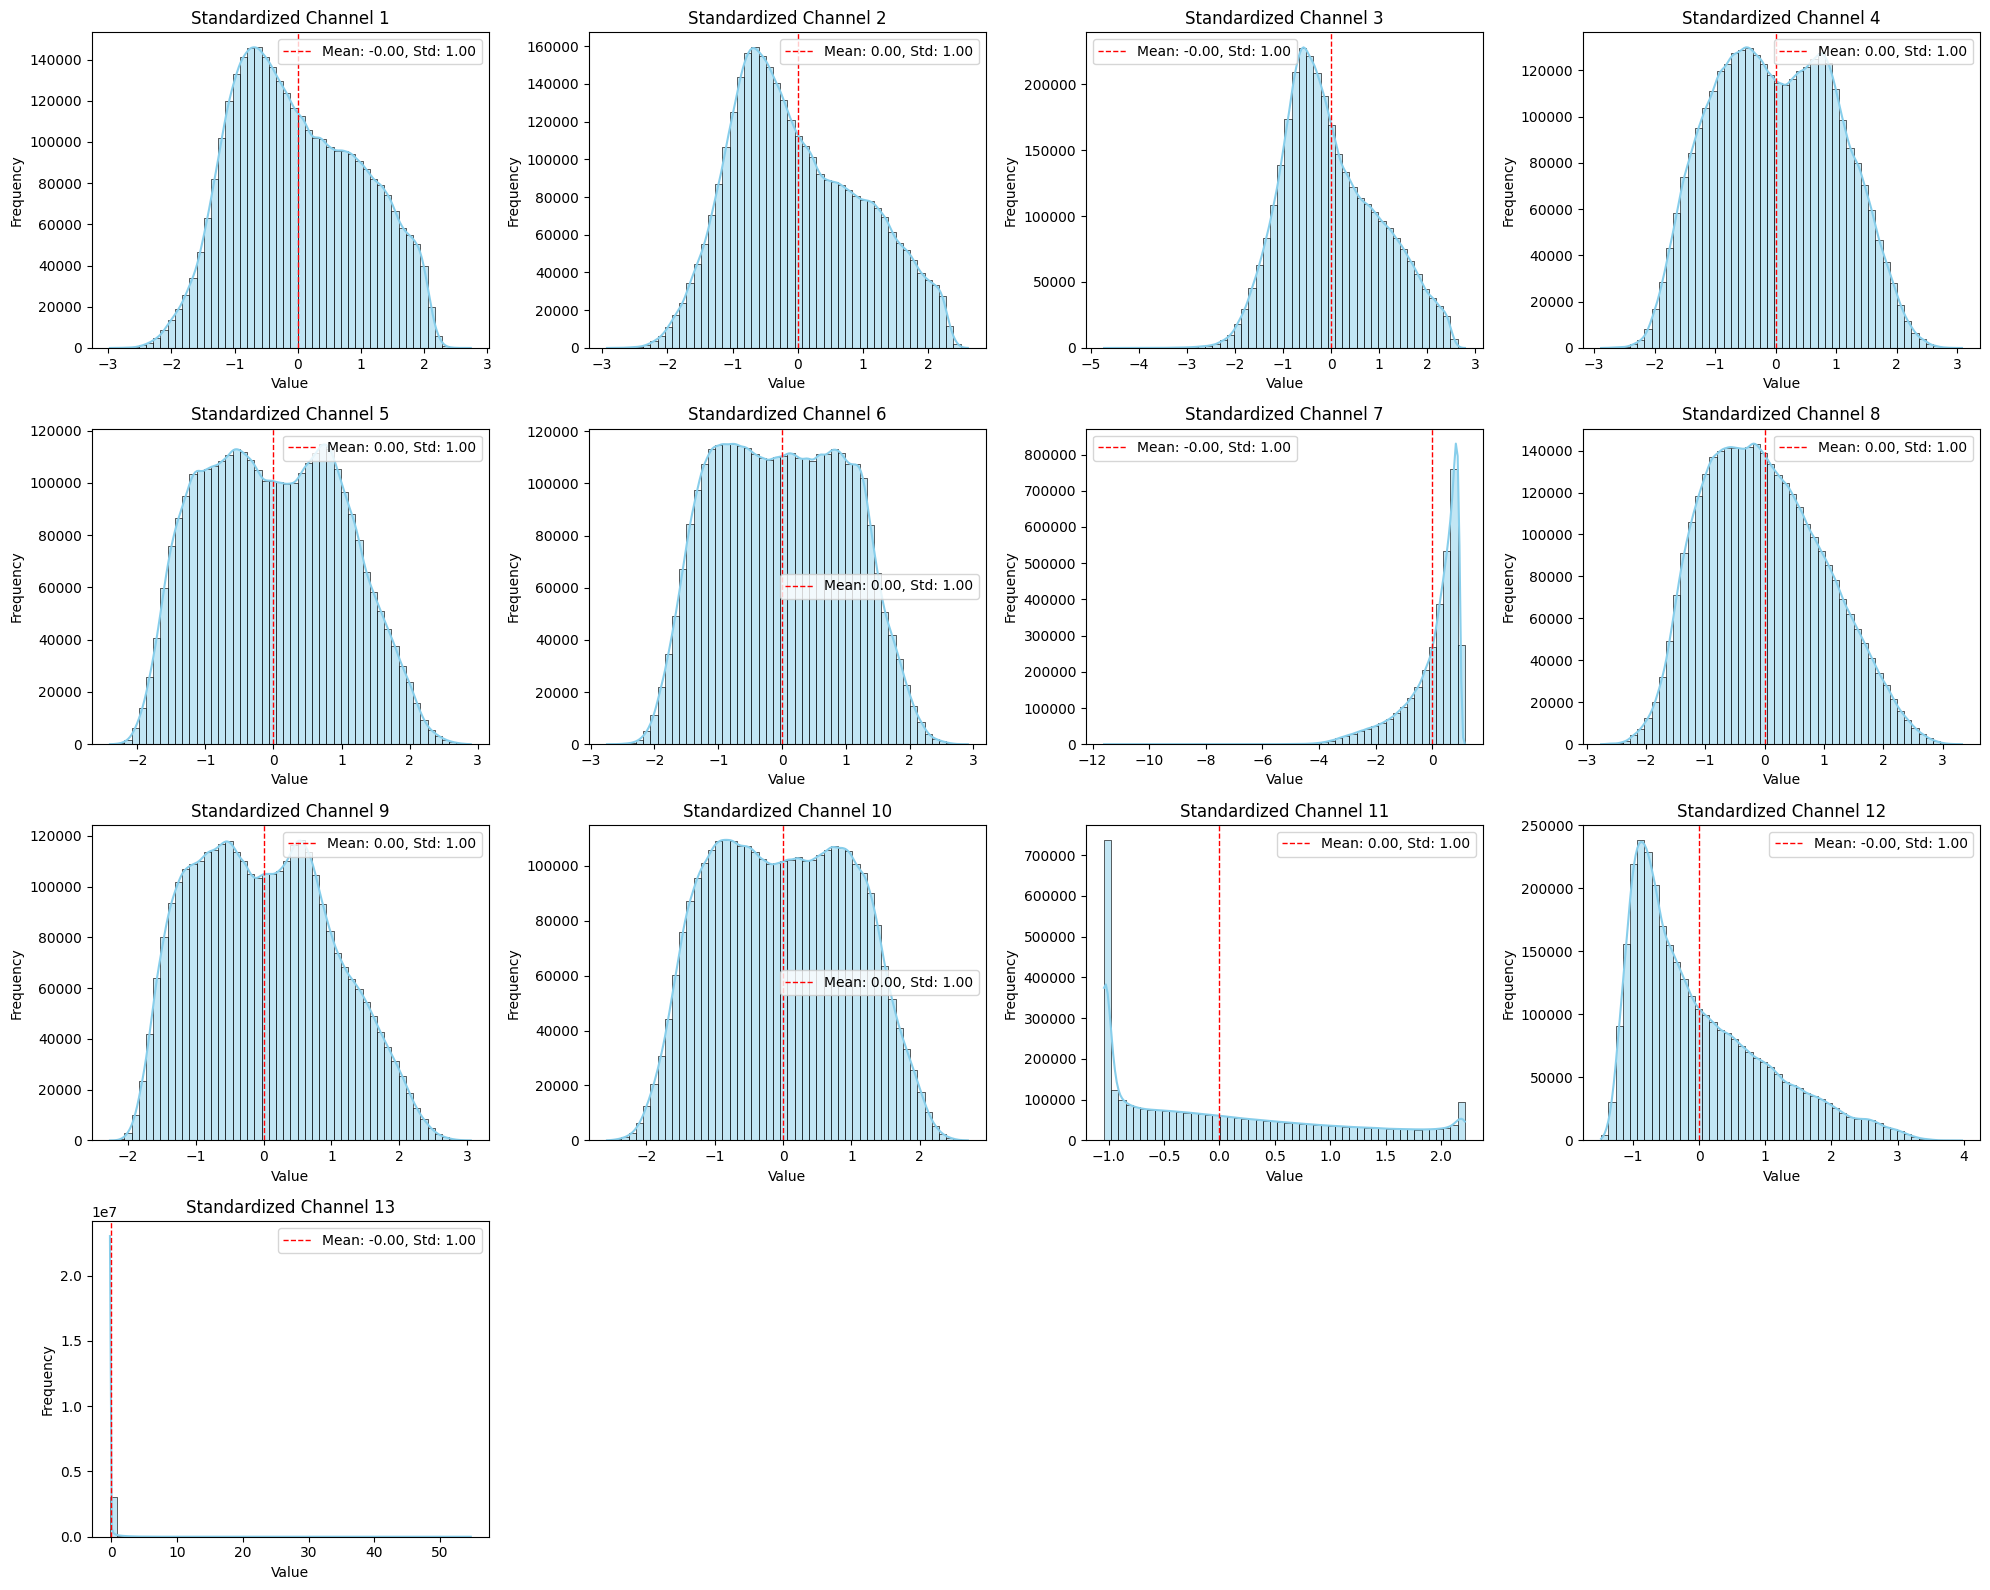

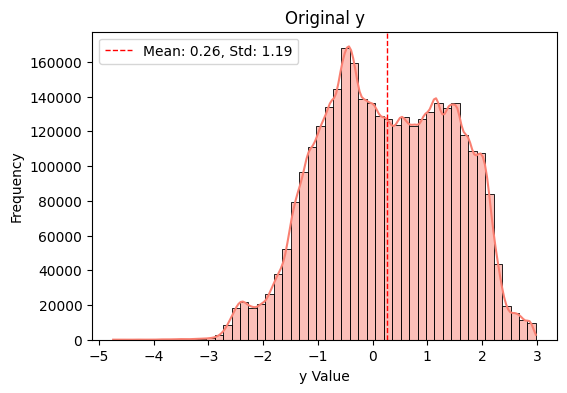

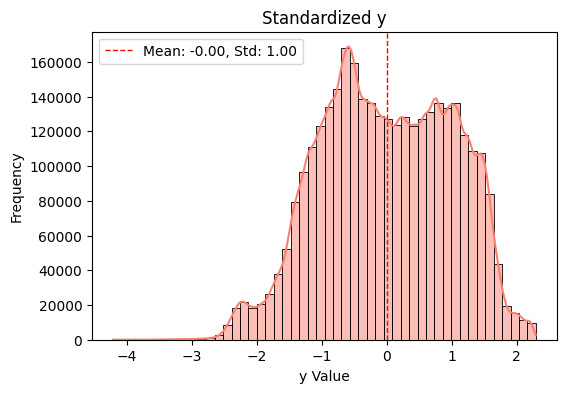


Outliers removed from test data per channel:
Channel 0: 0 outliers (0.00%)
Channel 1: 0 outliers (0.00%)
Channel 2: 0 outliers (0.00%)
Channel 3: 0 outliers (0.00%)
Channel 4: 0 outliers (0.00%)
Channel 5: 0 outliers (0.00%)
Channel 6: 34013 outliers (2.05%)
Channel 7: 0 outliers (0.00%)
Channel 8: 0 outliers (0.00%)
Channel 9: 0 outliers (0.00%)
Channel 10: 34013 outliers (2.05%)
Channel 11: 34013 outliers (2.05%)
Channel 12: 34013 outliers (2.05%)


In [7]:
# --- Standardization of input data (mean 0, std 1) ---

# Replace missing values in training data with NaNs
train_X[train_X == -9999.0] = np.nan
train_y[train_y == -9999.0] = np.nan

# Print original means per channel
print("Original channel means (before outlier removal):")
for c in range(train_X.shape[-1]):
    print(f"Channel {c}: {np.nanmean(train_X[..., c])}")

# Remove outliers from train_X (abs > 10000)
train_X_clean = train_X.copy()
outlier_mask = np.abs(train_X_clean) > 10000
train_X_clean[outlier_mask] = np.nan

print("\nOutliers removed per channel:")
for c in range(train_X.shape[-1]):
    outliers_in_channel = np.sum(outlier_mask[..., c])
    total_non_nan = np.sum(~np.isnan(train_X[..., c]))
    percentage = (outliers_in_channel / total_non_nan) * 100 if total_non_nan > 0 else 0
    print(f"Channel {c}: {outliers_in_channel} outliers ({percentage:.2f}% of non-NaN values)")

# Means after outlier removal
print("\nChannel means after outlier removal:")
for c in range(train_X_clean.shape[-1]):
    print(f"Channel {c}: {np.nanmean(train_X_clean[..., c])}")

# Standardize X
channels = train_X_clean.shape[-1]
scalers_X = [StandardScaler() for _ in range(channels)]
train_X_standardized = np.empty_like(train_X_clean)

for c in range(channels):
    channel_data = train_X_clean[..., c].reshape(-1, 1)
    valid_idx = ~np.isnan(channel_data).reshape(-1)

    if np.any(valid_idx):
        valid_data = channel_data[valid_idx]
        standardized = scalers_X[c].fit_transform(valid_data)

        full_data = np.full(channel_data.shape, np.nan)
        full_data[valid_idx] = standardized

        train_X_standardized[..., c] = full_data.reshape(train_X_clean.shape[:-1])
    else:
        train_X_standardized[..., c] = np.nan

# Standardize y
scaler_y = StandardScaler()
valid_y_idx = ~np.isnan(train_y.reshape(-1))
if np.any(valid_y_idx):
    valid_y = train_y.reshape(-1, 1)[valid_y_idx]
    standardized_valid_y = scaler_y.fit_transform(valid_y)

    train_y_standardized = np.full(train_y.reshape(-1, 1).shape, np.nan)
    train_y_standardized[valid_y_idx] = standardized_valid_y
    train_y_standardized = train_y_standardized.reshape(train_y.shape)
else:
    train_y_standardized = np.full(train_y.shape, np.nan)

# Print check stats
print("\nStandardized channel means:")
for c in range(channels):
    print(f"Channel {c}: {np.round(np.nanmean(train_X_standardized[..., c]), 2)}")
print(f"Standardized mean of train_y: {np.round(np.nanmean(train_y_standardized), 2)}")

print("\nStandardized channel std devs:")
for c in range(channels):
    print(f"Channel {c}: {np.round(np.nanstd(train_X_standardized[..., c]), 2)}")
print(f"Standardized std of train_y: {np.round(np.nanstd(train_y_standardized), 2)}")

# --- Histogram plotting ---

def plot_channel_histograms(data, title_prefix="", outlier_threshold=None):
    plot_data = data.copy()
    plot_data[plot_data == -9999.0] = np.nan
    num_channels = plot_data.shape[-1]
    cols = 4
    rows = int(np.ceil(num_channels / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i in range(num_channels):
        plt.subplot(rows, cols, i + 1)
        channel_data = plot_data[..., i].flatten()
        channel_data = channel_data[~np.isnan(channel_data)]

        if outlier_threshold:
            channel_data = channel_data[np.abs(channel_data) <= outlier_threshold]

        if len(channel_data) > 0:
            sns.histplot(channel_data, kde=True, bins=50, color='skyblue')
            mean_val = np.mean(channel_data)
            std_val = np.std(channel_data)
            plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1,
                        label=f'Mean: {mean_val:.2f}, Std: {std_val:.2f}')
            plt.legend()
            plt.title(f'{title_prefix} Channel {i+1}')
        else:
            plt.title(f'{title_prefix} Channel {i+1} - No Valid Data')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_y_histogram(y_data, title="y distribution"):
    data = y_data.copy().flatten()
    data = data[data != -9999.0]
    data = data[~np.isnan(data)]
    if len(data) == 0:
        print(f"No valid values in {title}")
        return

    plt.figure(figsize=(6, 4))
    sns.histplot(data, kde=True, bins=50, color='salmon')
    mean_val = np.mean(data)
    std_val = np.std(data)
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1,
                label=f'Mean: {mean_val:.2f}, Std: {std_val:.2f}')
    plt.legend()
    plt.title(title)
    plt.xlabel('y Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot original & standardized distributions
plot_channel_histograms(train_X, "Original (with outliers)")
plot_channel_histograms(train_X_clean, "Original (outliers removed)", outlier_threshold=10000)
plot_channel_histograms(train_X_standardized, "Standardized")
plot_y_histogram(train_y, "Original y")
plot_y_histogram(train_y_standardized, "Standardized y")

# --- Apply same transformation to test data ---

test_X[test_X == -9999.0] = np.nan
test_y[test_y == -9999.0] = np.nan

test_X_clean = test_X.copy()
test_outlier_mask = np.abs(test_X_clean) > 10000
test_X_clean[test_outlier_mask] = np.nan

print("\nOutliers removed from test data per channel:")
for c in range(test_X.shape[-1]):
    outliers = np.sum(test_outlier_mask[..., c])
    total = np.sum(~np.isnan(test_X[..., c]))
    percentage = (outliers / total) * 100 if total > 0 else 0
    print(f"Channel {c}: {outliers} outliers ({percentage:.2f}%)")

test_X_standardized = np.empty_like(test_X_clean)
for c in range(channels):
    channel_data = test_X_clean[..., c].reshape(-1, 1)
    valid_idx = ~np.isnan(channel_data).reshape(-1)

    if np.any(valid_idx):
        valid_data = channel_data[valid_idx]
        standardized = scalers_X[c].transform(valid_data)

        full_data = np.full(channel_data.shape, np.nan)
        full_data[valid_idx] = standardized

        test_X_standardized[..., c] = full_data.reshape(test_X_clean.shape[:-1])
    else:
        test_X_standardized[..., c] = np.nan

# Standardize y
valid_y_idx = ~np.isnan(test_y.reshape(-1))
if np.any(valid_y_idx):
    valid_y = test_y.reshape(-1, 1)[valid_y_idx]
    standardized_valid_y = scaler_y.transform(valid_y)

    test_y_standardized = np.full(test_y.reshape(-1, 1).shape, np.nan)
    test_y_standardized[valid_y_idx] = standardized_valid_y
    test_y_standardized = test_y_standardized.reshape(test_y.shape)
else:
    test_y_standardized = np.full(test_y.shape, np.nan)

# Replace NaNs with -9999.0
train_X_standardized[np.isnan(train_X_standardized)] = -9999.0
train_y_standardized[np.isnan(train_y_standardized)] = -9999.0
test_X_standardized[np.isnan(test_X_standardized)] = -9999.0
test_y_standardized[np.isnan(test_y_standardized)] = -9999.0

The distribution of Channel 13 appears unusual and inconsistent with the expected patterns. Upon inspection, this channel represents *total cloud cover*, a short-term atmospheric variable. Since cloud cover fluctuates rapidly and does not align well with the slower dynamics of drought development, its erratic distribution could introduce noise or bias into the model. For this reason, Channel 13 is excluded from the training data to ensure more stable and relevant inputs for drought prediction.

In [8]:
# Indices to exclude (0-based)
excluded_channels = [12]

# Keep all channels except the excluded ones
included_channels = [i for i in range(train_X_standardized.shape[-1]) if i not in excluded_channels]

# Subset X_train
train_X_standardized = train_X_standardized[..., included_channels]
print(f"Train X shape after channel exclusion: {train_X_standardized.shape}")

# Subset X_test
test_X_standardized = test_X_standardized[..., included_channels]
print(f"Test X shape after channel exclusion: {test_X_standardized.shape}")

Train X shape after channel exclusion: (396, 31, 20, 20, 12)
Test X shape after channel exclusion: (198, 31, 20, 20, 12)


In [9]:
# Check for NaNs in the standardized data
print(f"NaNs in train_X after standardization: {np.isnan(train_X_standardized).sum()}")
print(f"NaNs in train_y after standardization: {np.isnan(train_y_standardized).sum()}")

# Check for -9999 in the standardized data (correctly counting them)
print(f"Number of -9999 values in train_X: {(train_X_standardized == -9999).sum()}")
print(f"Number of -9999 values in train_y: {(train_y_standardized == -9999).sum()}")

# Check for NaNs in the standardized data
print(f"NaNs in test_X after standardization: {np.isnan(train_X_standardized).sum()}")
print(f"NaNs in test_y after standardization: {np.isnan(train_y_standardized).sum()}")

# Check for -9999 in the standardized data (correctly counting them)
print(f"Number of -9999 values in test_X: {(test_X_standardized == -9999).sum()}")
print(f"Number of -9999 values in test_y: {(test_y_standardized == -9999).sum()}")

NaNs in train_X after standardization: 0
NaNs in train_y after standardization: 0
Number of -9999 values in train_X: 19916748
Number of -9999 values in train_y: 1596562
NaNs in test_X after standardization: 0
NaNs in test_y after standardization: 0
Number of -9999 values in test_X: 9987528
Number of -9999 values in test_y: 798281


# Modelling

The data is split into training and validation using a sequential split to preserve the time series structure of the data.

In [10]:
# --- Train/Val Split ---

# Determine the number of samples in the training set
N = train_X_standardized.shape[0]

# Define the split index for an 80/20 train-validation split
split_idx = int(N * 0.8)

# Split the input features into training and validation sets
X_train = train_X_standardized[:split_idx]
X_val = train_X_standardized[split_idx:]

# Split the target variable (binary labels) into training and validation sets
y_train = train_y_standardized[:split_idx]
y_val = train_y_standardized[split_idx:]

**Model Architecture**

The model is a sequential CNN designed to process spatio-temporal data, leveraging 3D convolutions to capture both spatial and temporal dependencies. Here's a breakdown of the architecture:

- **Input Layer:** The model takes input data with the shape defined by input_shape. This shape represents data with dimensions of time, height, width, and channels.Input Masking: A Lambda layer applies a mask to the input data, replacing any values equal to -9999 with 0. This is crucial for handling missing or invalid data, ensuring these values do not adversely affect the model's learning process.

- **3D Convolutional Blocks:** The core of the model consists of four 3D convolutional (`Conv3D`) blocks.

  - Each Conv3D layer uses a (3, 3, 3) kernel to extract features from the input data across all three dimensions (time, height, and width). This allows the model to learn spatio-temporal patterns, such as how values change over time within a local spatial region.

  - The number of filters in these blocks increases progressively (32, 64, 64, 128), enabling the model to capture increasingly complex features. Early layers might detect simple patterns like edges and motion, while later layers combine these to recognize more intricate structures.

  - `padding='same'` ensures that the output of the convolutional layers has the same spatial dimensions as the input, preventing a reduction in size as data passes through the layers.
  
  - `activation='relu'` introduces non-linearity, allowing the model to learn non-linear relationships in the data.L2 regularization (`kernel_regularizer=l2(0.01)`) is applied to the Conv3D layers to prevent overfitting. This adds a penalty to the loss function based on the magnitude of the weights, encouraging the model to learn simpler patterns and reducing its reliance on any single feature.
  
  - Batch normalization (`BatchNormalization`) is applied after each Conv3D layer to stabilize training. It normalizes the activations of each layer, making the model less sensitive to the scale of the input data and allowing for the use of higher learning rates.
  
  - Spatial dropout (`SpatialDropout3D(0.2)`) is used to further prevent overfitting. Instead of randomly dropping individual neurons, it drops entire feature maps. This is more effective in convolutional layers because it forces the model to learn more robust features that are not dependent on the presence of specific feature maps.
  
- **Time Dimension Reduction:** A `Lambda` layer with `tf.reduce_mean(axis=1)` is used to reduce the time dimension of the feature maps. This step averages the features across all time steps, effectively summarizing the temporal information into a single representation. Importantly, the reduction is performed after the model has extracted spatio-temporal patterns using Conv3D layers, allowing it to leverage valuable temporal context early in the network. This reduction serves two key purposes:

  1. It decreases computational complexity and memory usage, enabling the use of more efficient 2D convolutional layers for further spatial refinement.

  2. It aligns with the structure of the target variable, which remains constant across time steps within each sample. Because the model is not required to predict temporal variation in the target, collapsing the time dimension at this stage removes redundant information and simplifies the learning objective without sacrificing predictive power.

- **2D Convolutional Blocks:** Two 2D convolutional (`Conv2D`) layers process the time-aggregated features. These layers further refine the spatial patterns, extracting relevant spatial information from the time-summarized data.
  - Similar to the Conv3D layers, these layers use relu activation and L2 regularization to improve performance and prevent overfitting.

- **Output Layer:** The final Conv2D layer with a single filter and a linear activation function produces the model's output. The linear activation is appropriate for a regression task, where the model predicts a continuous value.

**Training Process**

The model is trained using the following procedure:

- **Loss Function:** The `masked_mse` function is used as the loss function. This custom loss function calculates the mean squared error (MSE) only for the valid data points, ignoring the values where the target variable (`y_true`) is equal to -9999. This ensures that the model is not penalized for errors on missing or invalid data.

- **Optimizer:** The `Adam` optimizer with gradient clipping is used. Gradient clipping helps to stabilize training by preventing gradients from becoming too large, which can lead to instability.

- **Metrics:** The `masked_mae` function is used as an evaluation metric. Like the loss function, this metric calculates the mean absolute error (MAE) while ignoring the -9999 values in the target variable.

- **Early Stopping:** The `EarlyStopping` callback is used to prevent overfitting. This callback monitors the validation loss and stops training when it stops improving for a specified number of epochs (`patience=10`), restoring the model's weights to the best-performing epoch.

- **Time Dimension Reduction for Target:** The target variable `y_train` and `y_val` have their time dimension reduced using `tf.reduce_mean(axis=1)`. This is done to align the shape of the target variable with the output of the CNN, which has had its time dimension reduced by the Lambda layer in the model architecture.

- **Batch Size:** The model is trained using a batch size of 32.

**Handling of Spatial and Temporal Effects**

- **Spatial Effects:** The 2D and 3D convolutional layers capture spatial relationships. The filters in these layers slide across the spatial dimensions (height and width) of the input, learning to detect patterns such as edges, textures, and shapes.

- **Temporal Effects**: The 3D convolutional layers capture temporal relationships. The 3D filters extend along the time dimension, learning to recognize how spatial patterns evolve over time. This allows the model to understand motion and changes in the data over time. The subsequent time dimension reduction step aggregates this temporal information.

**Potential Struggles**

Despite the model's ability to capture spatio-temporal effects, it may face some challenges:

- **Long-Term Dependencies:** CNNs, by design, have a limited receptive field. While 3D CNNs extend this to the temporal dimension, capturing very long-term dependencies (e.g., patterns that span many time steps) can still be difficult.

- **Dimensionality Reduction:** Reducing the time dimension with a simple average might lose important temporal nuances.

In [22]:
# Custom loss function that ignores -9999 in y
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -9999), tf.float32)
    squared_error = tf.square(y_true - y_pred) * mask
    return tf.reduce_sum(squared_error) / tf.reduce_sum(mask)

def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -9999), tf.float32)
    abs_error = tf.abs(y_true - y_pred) * mask
    return tf.reduce_sum(abs_error) / tf.reduce_sum(mask)

# Define a function to create the 3D CNN model
def masked_3d_cnn(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    # Masking invalid values in the input
    model.add(layers.Lambda(lambda x: tf.where(x == -9999, 0.0, x)))

    conv_kwargs = dict(padding='same', activation='relu', kernel_regularizer=l2(0.01)) #added L2 regularization

    # Conv3D block 1
    model.add(layers.Conv3D(32, (3, 3, 3), **conv_kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.SpatialDropout3D(0.2)) # Increased dropout

    # Conv3D block 2
    model.add(layers.Conv3D(64, (3, 3, 3), **conv_kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.SpatialDropout3D(0.2)) # Increased dropout

    # Conv3D block 3
    model.add(layers.Conv3D(64, (3, 3, 3), **conv_kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.SpatialDropout3D(0.2)) # Increased dropout

    # Conv3D block 4
    model.add(layers.Conv3D(128, (3, 3, 3), **conv_kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.SpatialDropout3D(0.2)) # Increased dropout

    # Reduce time dimension
    model.add(layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)))  # shape: (batch, 20, 20, channels)

    # Conv2D block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))) #added L2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))) #added L2

    # Output layer for regression
    model.add(layers.Conv2D(1, (1, 1), activation='linear'))  # shape: (batch, 20, 20, 1)

    return model

def compile_and_fit(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Compiles and fits the model with the specified data and hyperparameters.

    Args:
        model: The TensorFlow Keras model to compile and fit.
        X_train: Training input data.
        y_train: Training target data.
        X_val: Validation input data.
        y_val: Validation target data.
        epochs: The number of epochs to train for.
        batch_size: The batch size to use during training.

    Returns:
        The training history object.
    """
    # Instantiate optimizer with gradient clipping
    optimizer = optimizers.Adam(clipnorm=1.0)  # Addressed unstable training

    # Compile model
    model.compile(optimizer=optimizer, loss=masked_mse,
                  metrics=[masked_mae])

    # Instantiate EarlyStopping callback
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Fit model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )
    return history

# Reduce the time dimension of the target variable
y_train_reduced = tf.reduce_mean(y_train, axis=1)
y_val_reduced = tf.reduce_mean(y_val, axis=1)

# Define input shape
input_shape = X_train.shape[1:]  # (31, 20, 20, 12)

# Create the model
model = masked_3d_cnn(input_shape)
model.summary()

# Compile and fit the model
history = compile_and_fit(model, X_train, y_train_reduced, X_val, y_val_reduced)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 31, 20, 20, 12) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 31, 20, 20, 32) │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 31, 20, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_8             │ (None, 31, 20, 20, 32) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 31, 20, 20, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_9             │ (None, 31, 20, 20, 64) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 31, 20, 20, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 31, 20, 20, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_10            │ (None, 31, 20, 20, 64) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 31, 20, 20,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 31, 20, 20,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout3d_11            │ (None, 31, 20, 20,     │             0 │
│ (SpatialDropout3D)              │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,169 (1.87 MB)

 Trainable params: 490,593 (1.87 MB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 4.6932 - masked_mae: 0.9209 - val_loss: 4.1585 - val_masked_mae: 0.8004
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - loss: 4.3030 - masked_mae: 0.8380 - val_loss: 6.3571 - val_masked_mae: 1.4111
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 4.0158 - masked_mae: 0.7944 - val_loss: 4.8357 - val_masked_mae: 1.1307
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 3.6576 - masked_mae: 0.7809 - val_loss: 4.5379 - val_masked_mae: 1.1076
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 3.3333 - masked_mae: 0.8000 - val_loss: 4.9897 - val_masked_mae: 1.2643
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - loss: 2.9318 - masked_mae: 0.7387 - val_loss: 2.9406 - val_masked_mae: 0.7962
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 2.9406 - masked_mae: 0.8379 - val_loss: 2.5883 - val_masked_mae: 0.7859
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 2.5736 - m

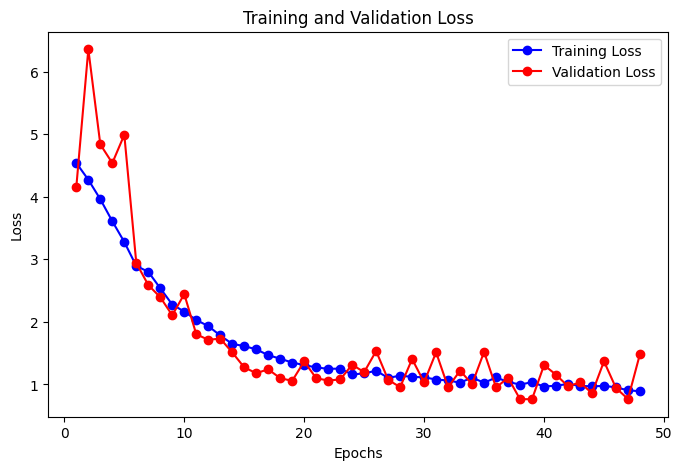

In [23]:
def plot_training_history(history):

    epochs = range(1, len(history.history['loss']) + 1)

    # Create a figure with two subplots.
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

    # Plot Loss.
    ax1.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    if 'val_loss' in history.history:
        ax1.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

plot_training_history(history)

**Interpretation of Training Output**

The model was trained over 42 epochs, and the performance metrics `loss` and `masked_mae` were tracked for both training and validation sets.

Initially, the model started with a high loss of **4.6932** and a validation loss of **4.1585** in epoch 1, indicating a poor initial fit. In the first few epochs (2–5), the validation performance fluctuated significantly, with `val_loss` spiking as high as **6.3571** in epoch 2, likely due to unstable early training dynamics or poor initial weights.

From epoch 6 onward, the model shows a notable decline in both training and validation loss, demonstrating that it is learning to generalise better. For instance, by epoch 9, the `val_loss` had dropped to **2.1051** with a `val_masked_mae` of **0.7491**, and by epoch 15, validation loss reached **1.2729**, indicating a clear improvement in predictive accuracy.

The best validation performance appeared around epochs 18–19 and again around epoch 38–39, where the model achieved a `val_loss` of **1.0575** and later even **0.7635**, with corresponding `val_masked_mae` as low as **0.6084**. This suggests that the model managed to capture important underlying patterns in the data.

However, some overfitting signs are present: despite a steady decline in training loss, validation loss occasionally spiked again (e.g., **1.5197** in epoch 35 and **1.3088** in epoch 40), indicating the model may have started to fit noise in the training data.

Overall, the model made meaningful progress in reducing prediction error and showed the ability to capture relevant patterns in the data. However, the relatively high masked MAE and validation MSE indicate that there is still considerable room for improvement. While the model converged and outperformed earlier approaches, the final performance suggests that the task remains challenging, possibly due to the complexity of the underlying patterns or limitations in CNNs. As this is the final architecture, it provides a solid foundation, but future work could explore more sophisticated architectures, better data preprocessing, or additional contextual information to further enhance predictive accuracy.



# Test Data Model Evaluation



The performance of the final model was assessed on the test set using the following four metrics:

1. **Mean Absolute Error (MAE):**
MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is calculated as the mean of the absolute differences between predicted and actual values. Lower MAE values indicate better predictive accuracy.

2. **Root Mean Squared Error (RMSE):** RMSE is the square root of the average of squared differences between prediction and actual observation. It penalizes larger errors more than MAE due to the squaring, making it more sensitive to outliers. Like MAE, lower RMSE values represent better performance.

3. **R-squared (R²):** Also known as the coefficient of determination, R² indicates the proportion of variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, with values closer to 1 indicating better fit. Negative values may occur if the model performs worse than a horizontal mean line.

4. **Nash-Sutcliffe Efficiency (NSE):** NSE is commonly used in hydrological modeling. It compares the predictive power of a model to the mean of the observed data. An NSE of 1 indicates a perfect match of modeled to observed data. An NSE of 0 means the model is only as accurate as the mean of the observed data, while negative values indicate the model performs worse than simply using the mean.


In [18]:
def compute_all_metrics(y_true, y_pred):

    # Flatten the arrays to simplify masking
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Create a mask for valid (non-missing) data points
    mask = (y_true_flat != -9999) & (y_pred_flat != -9999)

    # Apply the mask to get the clean data
    y_true_clean = y_true_flat[mask]
    y_pred_clean = y_pred_flat[mask]

    # Calculate the metrics using the clean data
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    # Calculate Nash-Sutcliffe Efficiency (NSE)
    nse_numerator = np.sum((y_true_clean - y_pred_clean) ** 2)
    nse_denominator = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
    nse = 1 - (nse_numerator / nse_denominator)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "NSE": nse
    }

def print_metrics(metrics_dict, title="Test Set Metrics"):
    print(f"\n{title}:")
    print("-" * (len(title) + 1))
    for k, v in metrics_dict.items():
        if isinstance(v, (np.float32, np.float64, float)):
            print(f"{k:20}: {v:.4f}")
        else:
            print(f"{k:20}: {v}")

The final model yielded the following performance metrics on the test set.

In [19]:
# Predict on test data
y_pred = model.predict(test_X_standardized)
y_true = test_y_standardized

# Reduce the time dimension of y_true to match y_pred
y_true_reduced = np.mean(y_true, axis=1)

metrics = compute_all_metrics(y_true_reduced, y_pred)
print_metrics(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step 

Test Set Metrics:
-----------------
MAE                 : 1.3627
RMSE                : 1.5868
R2                  : -2.4989
NSE                 : -2.4989


**Interpretation of Test Set Results**

The MAE of 1.36 means that, on average, the model's predictions deviate from the true standardized SPEI values by 1.36 standard deviations. This is a substantial error, indicating that the model is far from accurate in most cases.

The Root Mean Squared Error (RMSE) of 1.59 shows that the typical magnitude of the prediction error is about 1.59 standard deviations. Since RMSE penalizes larger errors more heavily than MAE, this suggests the model not only makes consistent errors but occasionally performs particularly poorly.

The R² value of -2.50 indicates that the model explains none of the variation in the test data and performs significantly worse than simply predicting the mean of the training set (which is zero due to standardisation).

The Nash-Sutcliffe Efficiency (NSE), which is mathematically equivalent to R² for standardized data, is also -2.50, further confirming the model’s poor performance.

**Possible Explanation**

There are a few plausible explanations for these results:

- The CNN-based architecture may be poorly suited to the specific spatiotemporal dynamics relevant for drought prediction using SPEI. While CNNs are effective at capturing local patterns, they may fail to represent long-range dependencies or subtle temporal interactions present in climate data.

- The training data only includes the years 2000 and 2001, while the test data is from 2002. If 2002 was an unusually dry or anomalous year (e.g., due to extreme weather events), the model may struggle to extrapolate from the relatively limited and potentially unrepresentative training data.

- The model may also be underfitting, failing to extract meaningful representations from the input data. This could be due to architectural limitations, lack of expressiveness, or insufficient training.

Although the model shows poor predictive performance, this analysis provides useful insights. It suggests the need to revisit the architecture (e.g., exploring temporal models like Transformers), increase the size and diversity of the training dataset, and examine the climate variability across years
more closely during evaluation.

**Model Selection**

Throughout the development process, a wide range of CNN architectures and training configurations were tested to improve performance. This included both deeper and lighter models, various kernel sizes, and combinations of pooling and dropout layers. Multiple optimisers (e.g., Adam, RMSprop, SGD) and
different learning rates were evaluated. Several regularisation strategies, such as dropout rates between 0.1 and 0.5, were applied to mitigate overfitting. Early stopping and learning rate reduction callbacks were also implemented in various combinations to enhance training stability and convergence.

Despite this extensive experimentation, the performance differences between the tested CNN architectures remained marginal. Most models converged to similar ranges of validation and test errors, indicating that the primary constraint might not be solely the architectural choices within the CNN framework. Instead, the inherent complexity of the data, the distributional shift between the training and testing years, or the fundamental limitations of CNNs in capturing complex temporal relationships could be more significant factors. This underscores the necessity of investigating fundamentally different modeling paradigms in future research, that explicitly address temporal dependencies.